In [25]:
!pip3 install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 28.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 7.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
file_paths = [
    './Data/BIIB.OQ.csv',
    './Data/BIO.N.csv',
    './Data/LKQ.OQ.csv',
    './Data/TXT.N.csv',
    './Data/VRSK.OQ.csv',
    './Data/MKTX.OQ.csv'
]

# Load the data
dataframes = [pd.read_csv(file) for file in file_paths]


In [3]:
processed_dfs = []
for df in dataframes:
    # Convert 'Date' to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Set the date and ticker symbol as a multi-index
    df.set_index(['Date', 'Instrument'], inplace=True)

    # Keep only the '1 Month Total Return' column
    df = df[['1 Month Total Return']]

    processed_dfs.append(df)

In [4]:
# Merge all dataframes on the multi-index
merged_data = pd.concat(processed_dfs, axis=0)

Estimate historical mean and variance covariance matrix of the stocks in your dataset. Estimate the variance covariance matrix with a Shrinkage toward Constant Correlation Approach (consider k=0.2). Estimate the vector of means with an exponential average (lambda=0.005). Comment on the correlation observed in your dataset.

In [5]:
# Define lambda parameter for exponential average
lambda_param = 0.005

# Calculate the exponential average of returns
exp_avg_returns = merged_data.groupby(level='Instrument').apply(lambda x: x.ewm(alpha=lambda_param).mean())
exp_avg_returns

1 Month Total Return
Instrument Date                      Instrument                      
BIIB.OQ    2004-01-30 00:00:00+00:00 BIIB.OQ                16.340402
           2004-02-27 00:00:00+00:00 BIIB.OQ                21.744004
           2004-03-31 00:00:00+00:00 BIIB.OQ                14.550265
           2004-04-30 00:00:00+00:00 BIIB.OQ                12.220466
           2004-05-28 00:00:00+00:00 BIIB.OQ                10.830338
...                                                               ...
VRSK.OQ    2023-07-31 00:00:00+00:00 VRSK.OQ                 1.503041
           2023-08-31 00:00:00+00:00 VRSK.OQ                 1.540937
           2023-09-29 00:00:00+00:00 VRSK.OQ                 1.508839
           2023-10-31 00:00:00+00:00 VRSK.OQ                 1.462740
           2023-11-30 00:00:00+00:00 VRSK.OQ                 1.515776

[1434 rows x 1 columns]

In [6]:
# Aggregate data to ensure unique entries for each stock per date
aggregated_data = merged_data.groupby(level=['Date', 'Instrument']).mean()

# Unstack the data after aggregation
unstacked_data = aggregated_data.unstack(level='Instrument')

# Calculate the historical variance-covariance matrix
var_cov_matrix = unstacked_data.cov()
var_cov_matrix

1 Month Total Return                        \
Instrument                                   BIIB.OQ      BIO.N     LKQ.OQ   
                     Instrument                                              
1 Month Total Return BIIB.OQ               98.491028  14.066107  13.585296   
                     BIO.N                 14.066107  62.431415  21.535464   
                     LKQ.OQ                13.585296  21.535464  74.616264   
                     MKTX.OQ               17.417318  29.516425  22.850067   
                     TXT.N                 17.396215  33.410230  38.492269   
                     VRSK.OQ               -0.871177  12.890438  12.322917   

                                                                    
Instrument                          MKTX.OQ       TXT.N    VRSK.OQ  
                     Instrument                                     
1 Month Total Return BIIB.OQ      17.417318   17.396215  -0.871177  
                     BIO.N        29.516425   33.410230  12.890438  
                     LKQ.OQ       22.850067   38.492269  12.322917  
                     MKTX.OQ     111.278210   38.155277   9.155613  
                     TXT.N        38.155277  147.855852  13.887012  
                     VRSK.OQ       9.155613   13.887012  32.816518

In [7]:
# Define the shrinkage parameter
k = 0.2

# Calculate the simple average of the variances
mean_variance = np.mean(np.diag(var_cov_matrix))

# Create a shrinkage target matrix (constant correlation matrix)
n_assets = var_cov_matrix.shape[0]
target = np.full_like(var_cov_matrix, mean_variance * (1 - k))
np.fill_diagonal(target, np.diag(var_cov_matrix))

# Apply shrinkage
shrunk_cov_matrix = k * target + (1 - k) * var_cov_matrix
shrunk_cov_matrix

1 Month Total Return                        \
Instrument                                   BIIB.OQ      BIO.N     LKQ.OQ   
                     Instrument                                              
1 Month Total Return BIIB.OQ               98.491028  25.319267  24.934618   
                     BIO.N                 25.319267  62.431415  31.294752   
                     LKQ.OQ                24.934618  31.294752  74.616264   
                     MKTX.OQ               28.000236  37.679521  32.346434   
                     TXT.N                 27.983353  40.794565  44.860196   
                     VRSK.OQ               13.369440  24.378732  23.924715   

                                                                    
Instrument                          MKTX.OQ       TXT.N    VRSK.OQ  
                     Instrument                                     
1 Month Total Return BIIB.OQ      28.000236   27.983353  13.369440  
                     BIO.N        37.679521   40.794565  24.378732  
                     LKQ.OQ       32.346434   44.860196  23.924715  
                     MKTX.OQ     111.278210   44.590603  21.390871  
                     TXT.N        44.590603  147.855852  25.175991  
                     VRSK.OQ      21.390871   25.175991  32.816518

In [8]:
# Calculate the correlation matrix
corr_matrix = unstacked_data.corr()
corr_matrix

1 Month Total Return                      \
Instrument                                   BIIB.OQ     BIO.N    LKQ.OQ   
                     Instrument                                            
1 Month Total Return BIIB.OQ                1.000000  0.179380  0.158473   
                     BIO.N                  0.179380  1.000000  0.315527   
                     LKQ.OQ                 0.158473  0.315527  1.000000   
                     MKTX.OQ                0.166496  0.350803  0.247446   
                     TXT.N                  0.144157  0.347743  0.366469   
                     VRSK.OQ               -0.015779  0.286779  0.271829   

                                                               
Instrument                        MKTX.OQ     TXT.N   VRSK.OQ  
                     Instrument                                
1 Month Total Return BIIB.OQ     0.166496  0.144157 -0.015779  
                     BIO.N       0.350803  0.347743  0.286779  
                     LKQ.OQ      0.247446  0.366469  0.271829  
                     MKTX.OQ     1.000000  0.291964  0.176924  
                     TXT.N       0.291964  1.000000  0.263755  
                     VRSK.OQ     0.176924  0.263755  1.000000

Compute and plot the efficient portfolio frontier with a risk-free asset. (Rf=0.01). Comment on the obtained risky asset portfolio. Would an investment manager like it?

In [9]:
# Calculate expected returns as the mean of historical returns
expected_returns = unstacked_data.mean(axis=0)

# Convert expected returns and covariance matrix to numpy arrays
expected_returns_array = expected_returns.to_numpy()
cov_matrix_array = shrunk_cov_matrix.to_numpy()

# Number of assets in the dataset
num_assets = len(expected_returns)

In [10]:
rf_rate = 0.01  # 1%

In [11]:
def portfolio_performance(weights):
    returns = np.sum(weights * expected_returns_array)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_array, weights)))
    return returns, volatility

In [12]:
def minimize_volatility(target_return):
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_performance(x)[0] - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((-1, 1) for asset in range(num_assets))
    result = minimize(lambda x: portfolio_performance(x)[1], np.array(num_assets*[1./num_assets,]), 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [13]:
target_returns = np.linspace(expected_returns_array.min(), expected_returns_array.max(), 50)
efficient_portfolios = [minimize_volatility(target) for target in target_returns]

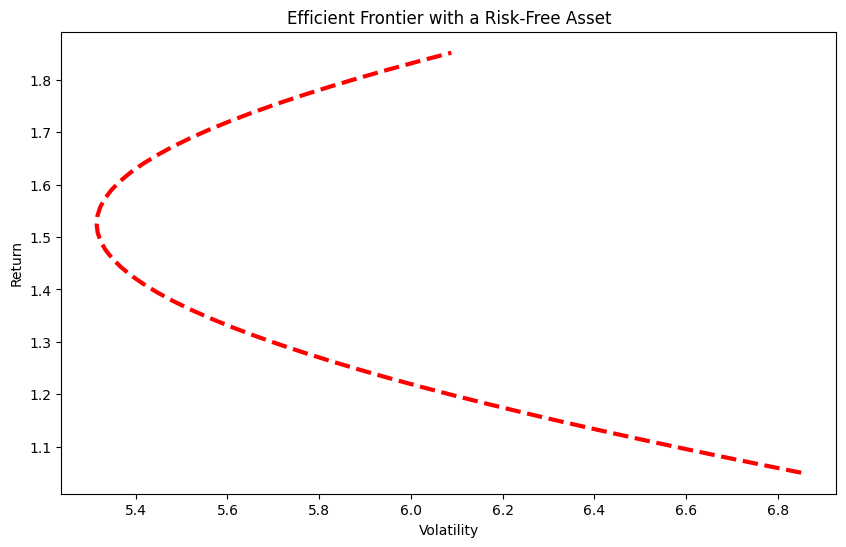

In [14]:
frontier_volatility = [p['fun'] for p in efficient_portfolios]
frontier_returns = [portfolio_performance(p['x'])[0] for p in efficient_portfolios]

plt.figure(figsize=(10, 6))
plt.plot(frontier_volatility, frontier_returns, 'r--', linewidth=3)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier with a Risk-Free Asset')
plt.show()

4. Compute and plot the efficient portfolio frontier with the same risk-free asset but imposing a no short-selling constraint. Comment on the differences on the portfolio with 0.5% monthly expected return with and without the short-selling constraint.

In [15]:
# Define the optimization function with no short-selling constraint
def minimize_volatility_no_short_selling(target_return, returns, cov_matrix, num_assets):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x * returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1./num_assets,]
    result = minimize(lambda x: np.sqrt(np.dot(x.T, np.dot(cov_matrix, x))), initial_guess,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [16]:
# Compute efficient frontier with no short-selling constraint
target_returns_no_short = np.linspace(expected_returns_array.min(), expected_returns_array.max(), 50)
efficient_portfolios_no_short = [minimize_volatility_no_short_selling(target, expected_returns_array, cov_matrix_array, num_assets) for target in target_returns_no_short]

In [17]:
# Extract volatilities and returns for the efficient frontier with no short-selling
frontier_volatility_no_short = [np.sqrt(np.dot(p['x'].T, np.dot(cov_matrix_array, p['x']))) for p in efficient_portfolios_no_short]
frontier_returns_no_short = [np.sum(p['x'] * expected_returns_array) for p in efficient_portfolios_no_short]

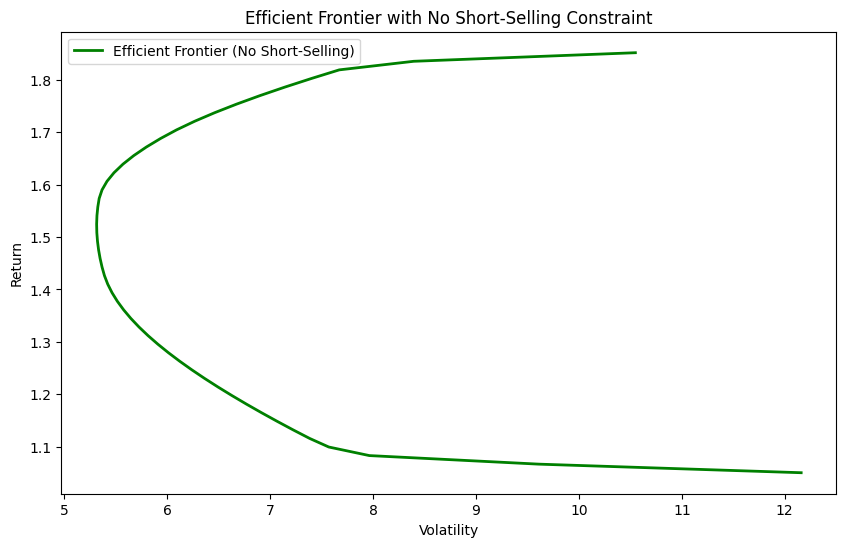

In [18]:
# Plot the efficient frontier with no short-selling constraint
plt.figure(figsize=(10, 6))
plt.plot(frontier_volatility_no_short, frontier_returns_no_short, 'g-', linewidth=2, label='Efficient Frontier (No Short-Selling)')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier with No Short-Selling Constraint')
plt.legend()
plt.show()

In [19]:
# Calculate portfolio weights with short-selling for a 0.5% monthly expected return
target_return_05 = 0.005  # 0.5% monthly return
portfolio_with_short_selling = minimize_volatility(target_return_05)
portfolio_weights_with_short_selling = portfolio_with_short_selling['x']

In [20]:
# Compute the no short-selling portfolio for the same target return
portfolio_no_short_selling = minimize_volatility_no_short_selling(target_return_05, expected_returns_array, cov_matrix_array, num_assets)
portfolio_weights_no_short_selling = portfolio_no_short_selling['x']

# Compare the weights
print("Portfolio Weights with Short-Selling Constraint:", portfolio_weights_with_short_selling)
print("Portfolio Weights without Short-Selling Constraint:", portfolio_weights_no_short_selling)

Portfolio Weights with Short-Selling Constraint: [ 0.44626867  1.         -1.         -0.95092349  0.9816521   0.52300272]
Portfolio Weights without Short-Selling Constraint: [8.03801420e-14 9.49725218e-12 1.41331435e-13 1.18514913e-12
 1.00000000e+00 2.23898591e-18]


5.	Estimate CAPM alpha and beta for your stock, use the returns of the S&P 500 as proxy for the market returns. Comment on the results, which of the stocks have generated alpha in the previous years.

In [21]:
# Load S&P 500 data
sp500_data_path = './Data/SPX.csv'
sp500_data = pd.read_csv(sp500_data_path)

# Convert 'Date' to datetime and set as index
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

# Calculate monthly returns for S&P 500
sp500_data['SPX_Returns'] = sp500_data['Price Close'].pct_change()

In [22]:
# Aligning stock returns with S&P 500 returns
aligned_data = unstacked_data['1 Month Total Return'].align(sp500_data['SPX_Returns'], axis=0, join='inner')
stock_returns, market_returns = aligned_data[0], aligned_data[1]

In [26]:
# Perform regression analysis for each stock
for stock in stock_returns.columns:
    # Prepare data for regression
    X = sm.add_constant(market_returns)  # Market returns
    y = stock_returns[stock]  # Stock returns

    # Perform linear regression
    model = sm.OLS(y, X, missing='drop').fit()
    alpha, beta = model.params

    # Output results
    print(f"Stock: {stock}")
    print(f"Alpha (α): {alpha}, Beta (β): {beta}\n")

Stock: BIIB.OQ
Alpha (α): 0.9459087843297856, Beta (β): 60.010781995631945

Stock: BIO.N
Alpha (α): 0.4223437372149047, Beta (β): 104.14094372718729

Stock: LKQ.OQ
Alpha (α): 1.0477469214799908, Beta (β): 109.75653880108294

Stock: MKTX.OQ
Alpha (α): 1.2285468444286733, Beta (β): 87.950946026265

Stock: TXT.N
Alpha (α): -0.2320215043620085, Beta (β): 192.82748199455455

Stock: VRSK.OQ
Alpha (α): 0.939922666571638, Beta (β): 62.93362273439004

